1A

Epoch 1, loss: 2.2560811545842747, test accuracy: 24.96 %
Epoch 2, loss: 1.9832266610296791, test accuracy: 34.27 %
Epoch 3, loss: 1.8023667733382691, test accuracy: 40.01 %
Epoch 4, loss: 1.6694209882060584, test accuracy: 42.12 %
Epoch 5, loss: 1.592160831631907, test accuracy: 44.3 %
Epoch 6, loss: 1.5387708305397911, test accuracy: 45.39 %
Epoch 7, loss: 1.4978285277895915, test accuracy: 47.01 %
Epoch 8, loss: 1.4607371258003938, test accuracy: 48.8 %
Epoch 9, loss: 1.4259776102612391, test accuracy: 49.98 %
Epoch 10, loss: 1.391076830646876, test accuracy: 50.94 %
Epoch 11, loss: 1.357131886512727, test accuracy: 52.39 %
Epoch 12, loss: 1.3211850623035675, test accuracy: 53.83 %
Epoch 13, loss: 1.2947180122518174, test accuracy: 54.07 %
Epoch 14, loss: 1.2699536881635867, test accuracy: 54.22 %
Epoch 15, loss: 1.2444965872923126, test accuracy: 56.1 %
Epoch 16, loss: 1.2238254583705113, test accuracy: 55.39 %
Epoch 17, loss: 1.2043936365400738, test accuracy: 56.76 %
Epoch 18, lo

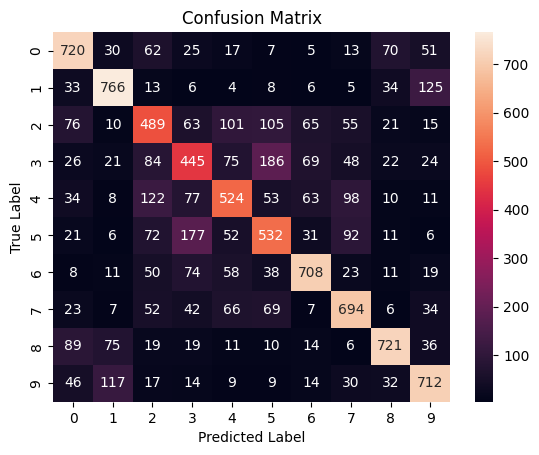

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import pickle
import time
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.tanh1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.tanh2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.tanh3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)  # Adjusted to 10 for CIFAR-10 classes

    def forward(self, x):
        x = self.pool1(self.tanh1(self.conv1(x)))
        x = self.pool2(self.tanh2(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 8)
        x = self.tanh3(self.fc1(x))
        x = self.fc2(x)
        return x

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []

    for i in range(1, 6):
        data_batch, label_batch = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        data_batch = data_batch.reshape(-1, 3, 32, 32)
        train_data.append(data_batch)
        train_labels.append(label_batch)

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    test_data = test_data.reshape(-1, 3, 32, 32)

    return train_data, train_labels, test_data, test_labels

def evaluate_accuracy(data_loader, model, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

if __name__ == "__main__":
    cifar10_dir = 'C:/Users/SirM/Desktop/Swayam/Intro To ML/cifar-10-batches-py'
    train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar10_dir)

    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    train_data /= 255.0
    test_data /= 255.0

    trainloader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(list(zip(test_data, test_labels)), batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_model = CNN().to(device)
    optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(300):  
        running_loss = 0.0
        cnn_model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluate on test data
        cnn_model.eval()  # Set the model to evaluation mode
        test_accuracy = evaluate_accuracy(testloader, cnn_model, device)
        print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}, test accuracy: {test_accuracy} %')

    end_time = time.time()
    training_time = end_time - start_time
    print('Training time: ', training_time)

    # Final model evaluation
    cnn_model.eval()
    final_accuracy = evaluate_accuracy(testloader, cnn_model, device)
    print(f'Final Accuracy: {final_accuracy} %')

    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'F1 Score: {f1}')

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


1B

Epoch 1, Loss: 2.3003811406357513, Test Accuracy: 14.0 %
Epoch 2, Loss: 2.270787401272513, Test Accuracy: 23.36 %
Epoch 3, Loss: 2.0432165380938887, Test Accuracy: 29.25 %
Epoch 4, Loss: 1.9119997085512752, Test Accuracy: 35.6 %
Epoch 5, Loss: 1.7467537668659865, Test Accuracy: 41.6 %
Epoch 6, Loss: 1.615117018180125, Test Accuracy: 44.62 %
Epoch 7, Loss: 1.5354264393791823, Test Accuracy: 46.88 %
Epoch 8, Loss: 1.4821643211957438, Test Accuracy: 49.2 %
Epoch 9, Loss: 1.436478109920726, Test Accuracy: 50.88 %
Epoch 10, Loss: 1.3955418417215957, Test Accuracy: 50.5 %
Epoch 11, Loss: 1.356281066260984, Test Accuracy: 52.72 %
Epoch 12, Loss: 1.3118892504888422, Test Accuracy: 54.76 %
Epoch 13, Loss: 1.2728152654664902, Test Accuracy: 56.47 %
Epoch 14, Loss: 1.238627738659949, Test Accuracy: 57.24 %
Epoch 15, Loss: 1.200080061126548, Test Accuracy: 57.9 %
Epoch 16, Loss: 1.1700461323913711, Test Accuracy: 59.38 %
Epoch 17, Loss: 1.1314807425984337, Test Accuracy: 59.07 %
Epoch 18, Loss: 1.

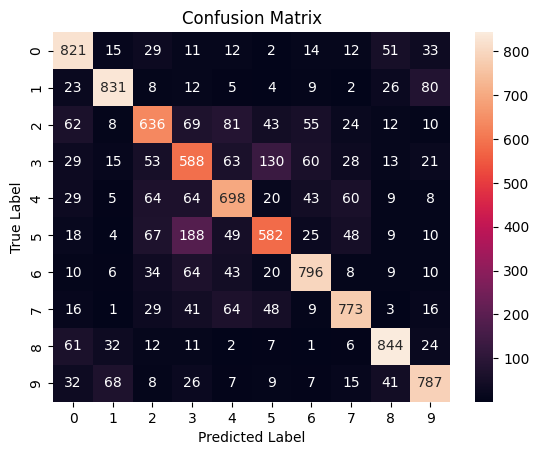

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import pickle
import time
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []

    for i in range(1, 6):
        data_batch, label_batch = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        data_batch = data_batch.reshape(-1, 3, 32, 32)
        train_data.append(data_batch)
        train_labels.append(label_batch)

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    test_data = test_data.reshape(-1, 3, 32, 32)

    return train_data, train_labels, test_data, test_labels

def evaluate_accuracy(data_loader, model, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

if __name__ == "__main__":
    cifar10_dir = 'C:/Users/SirM/Desktop/Swayam/Intro To ML/cifar-10-batches-py'
    train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar10_dir)

    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    train_data /= 255.0
    test_data /= 255.0

    trainloader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(list(zip(test_data, test_labels)), batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_model = CNN().to(device)
    optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(300):
        running_loss = 0.0
        cnn_model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluate on test data
        cnn_model.eval()
        test_accuracy = evaluate_accuracy(testloader, cnn_model, device)
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Test Accuracy: {test_accuracy} %')

    end_time = time.time()
    training_time = end_time - start_time
    print('Total Training Time: ', training_time)

    # Final evaluation of the model
    cnn_model.eval()
    final_accuracy = evaluate_accuracy(testloader, cnn_model, device)
    print(f'Final Accuracy: {final_accuracy} %')

    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'F1 Score: {f1}')

    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np

# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

# ResNet-10 Model
class ResNet10(nn.Module):
    def __init__(self):
        super(ResNet10, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 64, stride=1, num_blocks=1)
        self.layer2 = self._make_layer(64, 128, stride=2, num_blocks=1)
        self.layer3 = self._make_layer(128, 256, stride=2, num_blocks=1)
        self.layer4 = self._make_layer(256, 512, stride=2, num_blocks=1)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Load CIFAR-10 Data
def load_cifar10_data(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

# Evaluate Model
def evaluate_model(model, testloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train the Model
def train_model(model, trainloader, testloader, device, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print statistics
        running_loss /= len(trainloader)
        accuracy = evaluate_model(model, testloader, device)
        print(f'Epoch {epoch + 1} - Loss: {running_loss:.3f}, Accuracy: {accuracy:.2f}%')

    print('Finished Training')
    return model

# Main Function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')

    trainloader, testloader = load_cifar10_data()
    resnet10 = ResNet10().to(device)

    start_time = time.time()
    trained_model = train_model(resnet10, trainloader, testloader, device, num_epochs=300)
    end_time = time.time()

    training_time = end_time - start_time
    final_accuracy = evaluate_model(trained_model, testloader, device)

    print(f'Total Training Time: {training_time:.2f} seconds')
    print(f'Final Evaluation Accuracy: {final_accuracy:.2f}%')

if __name__ == "__main__":
    main()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1 - Loss: 1.475, Accuracy: 56.15%
Epoch 2 - Loss: 1.055, Accuracy: 65.26%
Epoch 3 - Loss: 0.859, Accuracy: 69.04%
Epoch 4 - Loss: 0.701, Accuracy: 70.89%
Epoch 5 - Loss: 0.577, Accuracy: 74.25%
Epoch 6 - Loss: 0.459, Accuracy: 75.11%
Epoch 7 - Loss: 0.349, Accuracy: 75.25%
Epoch 8 - Loss: 0.245, Accuracy: 75.39%
Epoch 9 - Loss: 0.161, Accuracy: 75.02%
Epoch 10 - Loss: 0.100, Accuracy: 74.96%
Epoch 11 - Loss: 0.059, Accuracy: 76.26%
Epoch 12 - Loss: 0.028, Accuracy: 77.16%
Epoch 13 - Loss: 0.015, Accuracy: 77.03%
Epoch 14 - Loss: 0.011, Accuracy: 77.40%
Epoch 15 - Loss: 0.007, Accuracy: 77.36%
Epoch 16 - Loss: 0.005, Accuracy: 77.36%
Epoch 17 - Loss: 0.004, Accuracy: 77.68%
Epoch 18 - Loss: 0.003, Accuracy: 77.59%
Epoch 19 - Loss: 0.003, Accuracy: 77.65%
Epoch 20 - Loss: 0.003, Accuracy: 77.65%
Epoch 21 - Loss: 0.002, Accuracy: 77.72%
Epoch 22 - Loss: 0.002, Accuracy: 77.65%
Epoch 23 - L